In [1]:
import metpy
import datetime
import rioxarray
import os
import glob
import warnings
import haversine

import geopandas as gpd
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.feature as cfeature

from plotting import histogram_density_plot

save_path = 'figures and data/'

In [2]:
regions = gpd.read_file('data/Natural_Earth_quick_start/50m_cultural/ne_50m_admin_1_states_provinces_lakes.shp')
states = regions[regions.admin == 'United States of America']
contiguous_us = states[(states.name != 'Alaska') & (states.name != 'Hawaii')]

In [3]:
equal_area = ccrs.AlbersEqualArea(central_latitude=39.8283, central_longitude=-98.5795)
plate = ccrs.PlateCarree()

In [4]:
epa = pd.read_csv('/Volumes/Minuet/research/EPA/daily_88101_2021.csv')
epa.rename({'Longitude':'longitude', 'Latitude':'latitude'}, axis=1, inplace=True)
epa_locations = epa[['latitude', 'longitude']].drop_duplicates(
    ).reset_index(drop=True).sort_values(by='latitude')

In [5]:
def plot_locations(locations, ax, color='red', **kwargs):
    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

    def colorize_state(geometry):
        facecolor = (0.9375, 0.9375, 0.859375)
        return {'facecolor': facecolor, 'edgecolor': '#00000033'}

    ax.add_geometries(
        contiguous_us.geometry,
        ccrs.PlateCarree(),
        styler=colorize_state)

    ax.set_extent([-120, -72, 25, 48.8], plate)

    ax.scatter(locations.longitude, locations.latitude,
           s=4, 
           alpha=0.4, 
           c=color,
           edgecolor='black',
           transform=ccrs.PlateCarree(), 
           zorder=10, **kwargs);

    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, alpha=0.2)
    gl.top_labels=False
    gl.right_labels=False
    xstyle = {'size': 8, 'rotation': 0, 'ha': 'center'}
    ystyle = {'size': 8, 'rotation': 0}
    gl.xlabel_style = xstyle
    gl.ylabel_style = ystyle
    ax.spines[:].set_visible(False)

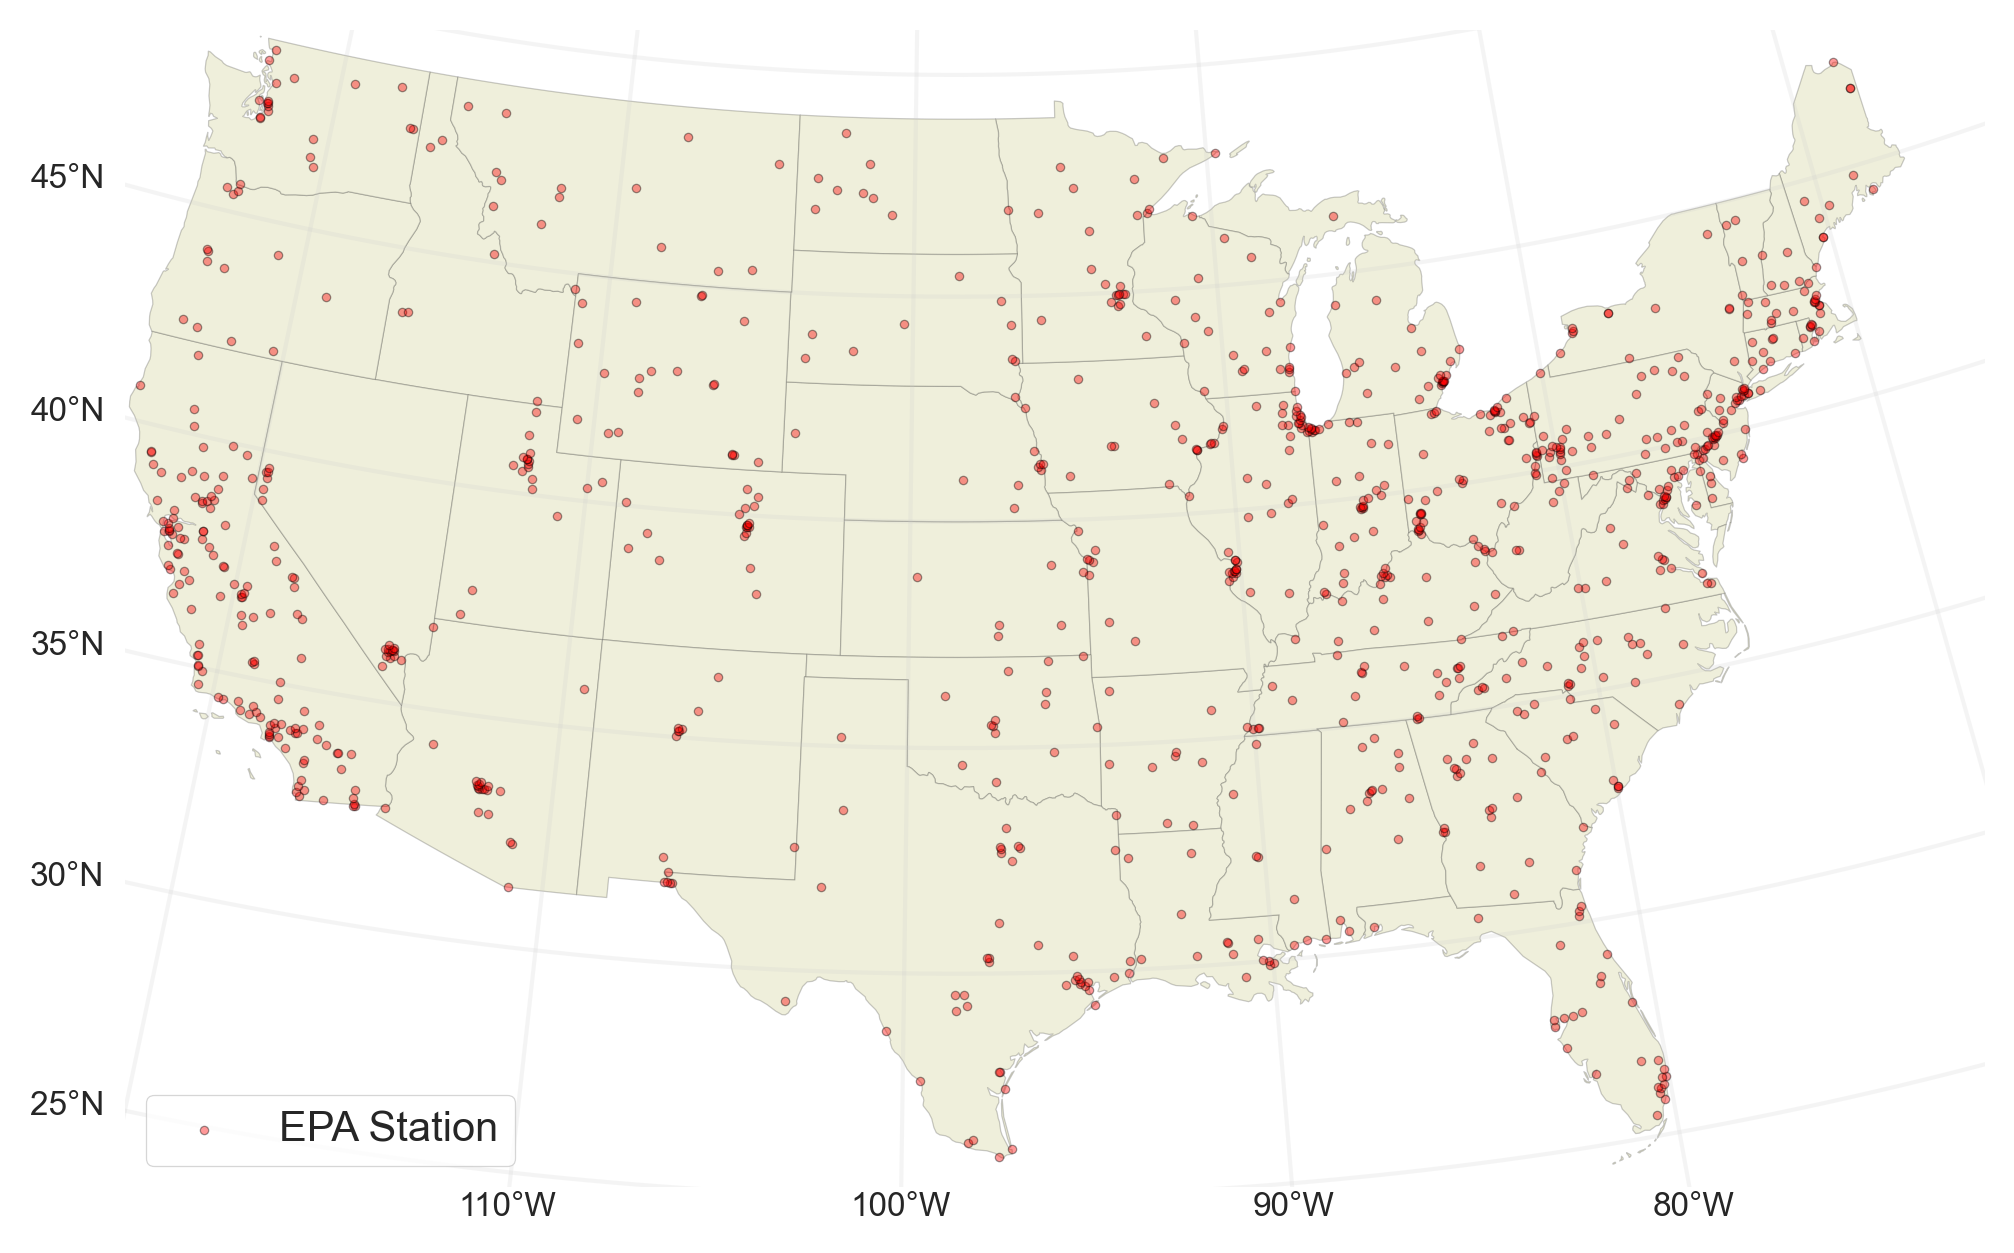

In [6]:
fig, ax = plt.subplots(dpi=300, subplot_kw=dict(projection=equal_area))
plot_locations(epa_locations, ax=ax, label='EPA Station')

ax.legend(frameon=True)

fig.savefig(f'{save_path}/epa_locations.png', format='png', bbox_inches = "tight")

In [4]:
df = pd.read_csv('data/matched/all_years_months.csv', parse_dates=['time'])
df.rename({'lon':'longitude', 'lat':'latitude'}, axis=1, inplace=True)
matched_locations = df[['latitude', 'longitude']].drop_duplicates(
    ).reset_index(drop=True).sort_values(by='latitude')

In [8]:
dist = haversine.haversine_vector(epa_locations.values, matched_locations.values, comb=True)

matched_locations['loc'] = matched_locations.longitude.astype(str) + "," + matched_locations.latitude.astype(str)
epa_locations['loc'] = epa_locations.longitude.astype(str) + "," + epa_locations.latitude.astype(str)

distances = pd.DataFrame(dist.T, columns=matched_locations['loc'].values, index=epa_locations['loc'].values)

In [9]:
all_locs = [eval(i) for i in distances.index.values]
matched = [eval(i) for i in distances[distances < 2].dropna(how='all').index.values]
unmatched = list(set(all_locs).difference(set(matched)))

matched = pd.DataFrame(matched, columns = ['longitude', 'latitude'])
unmatched = pd.DataFrame(unmatched, columns = ['longitude', 'latitude'])

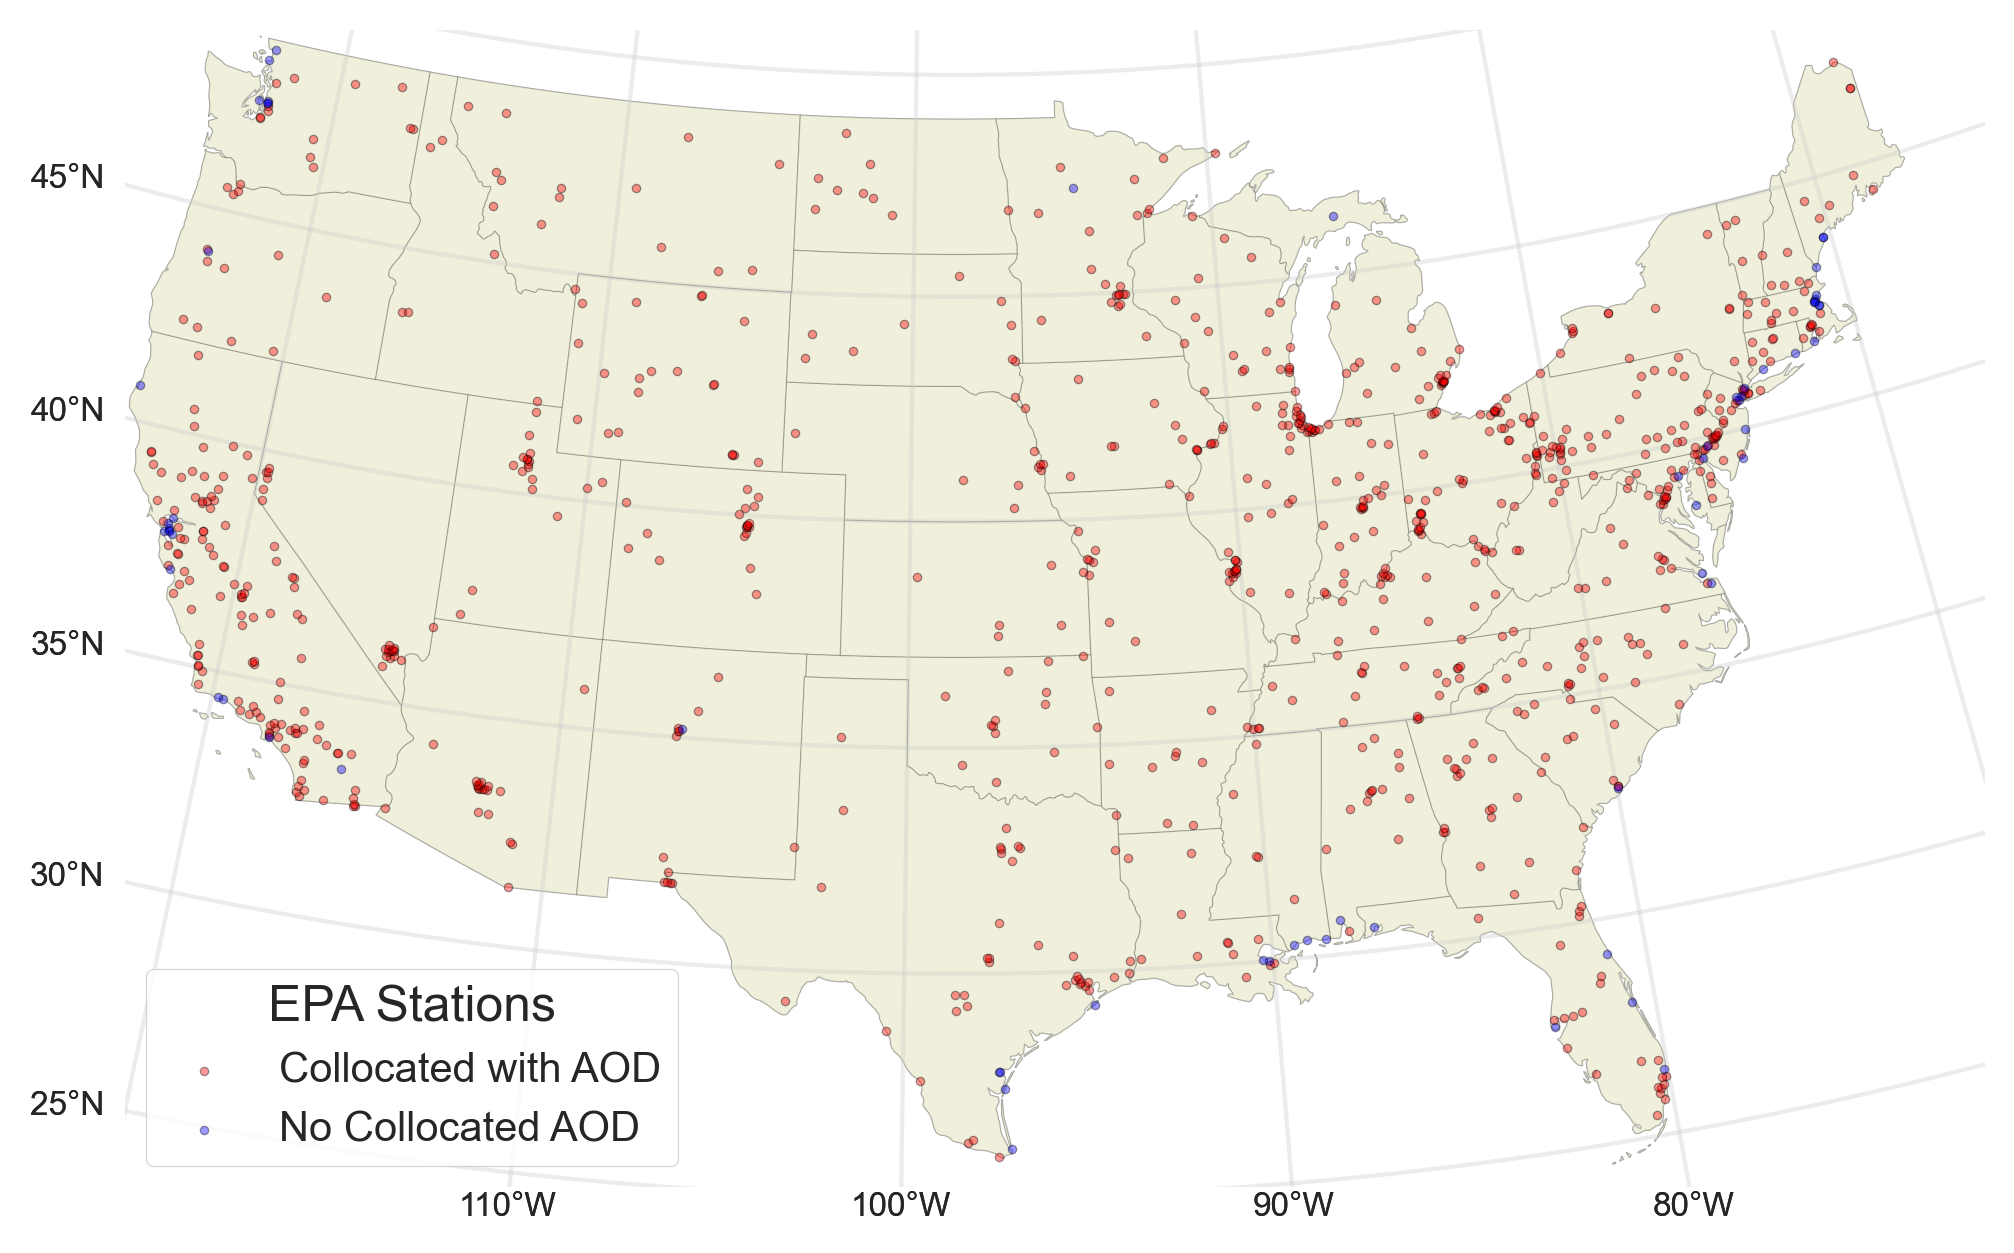

In [10]:
fig, ax = plt.subplots(dpi=300, subplot_kw=dict(projection=equal_area))
plot_locations(
    matched,
    ax=ax, label='Collocated with AOD'
)
plot_locations(
    unmatched,
    ax=ax, color='blue', label='No Collocated AOD')

ax.legend(frameon=True, title='EPA Stations')

fig.savefig(f'{save_path}/collocated_and_uncollated_epa_locations.png', format='png', bbox_inches = "tight")

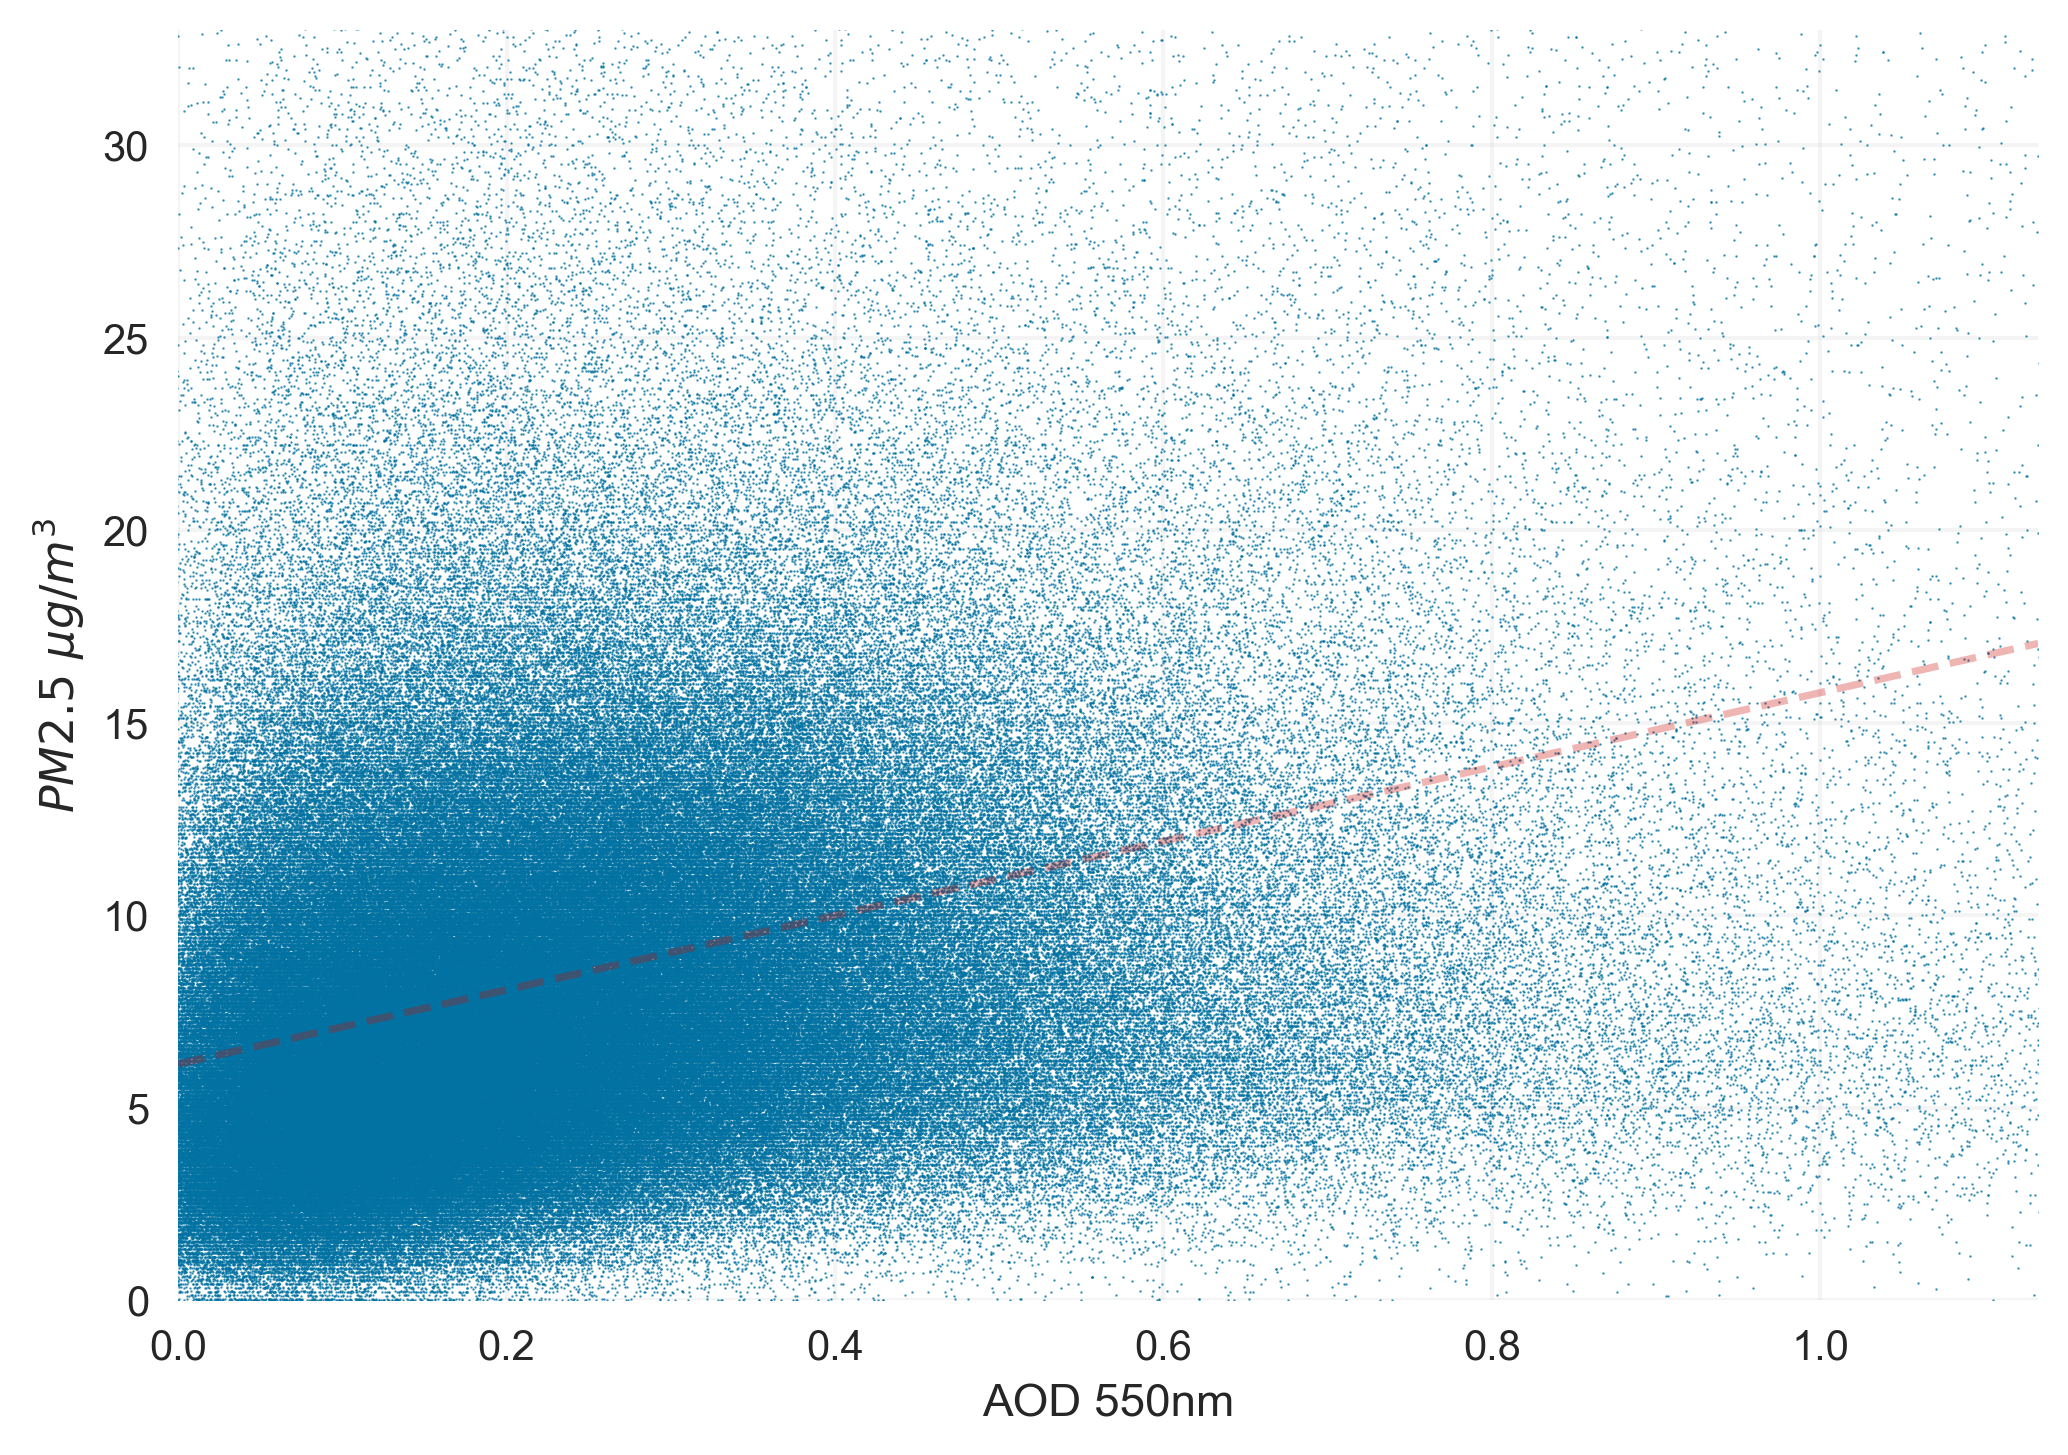

In [20]:
from sklearn.linear_model import LinearRegression
fig, ax = plt.subplots(dpi=300)

x = df.AOD
y = df.PM25

lin = LinearRegression().fit(x.values.reshape(-1, 1), y)

ax.scatter(x, y, s=0.1, alpha=0.6)

ax.axline(xy1=(0, lin.intercept_), slope=lin.coef_.item(), linestyle="--", color="r", alpha=0.3)

ax.set_xlim((0, np.percentile(x, 99)))
ax.set_ylim((0, np.percentile(y, 99)))

ax.set_xlabel('AOD 550nm')
ax.set_ylabel('$PM2.5~ \mu g/m^3$')

ax.tick_params(width=0)
ax.grid(alpha=0.2)
for spine in ['top', 'left', 'bottom', 'right']:
    ax.spines[spine].set_visible(False)
    
fig.savefig(f'{save_path}/aod-pm-scatter.png', format='png', bbox_inches = "tight")

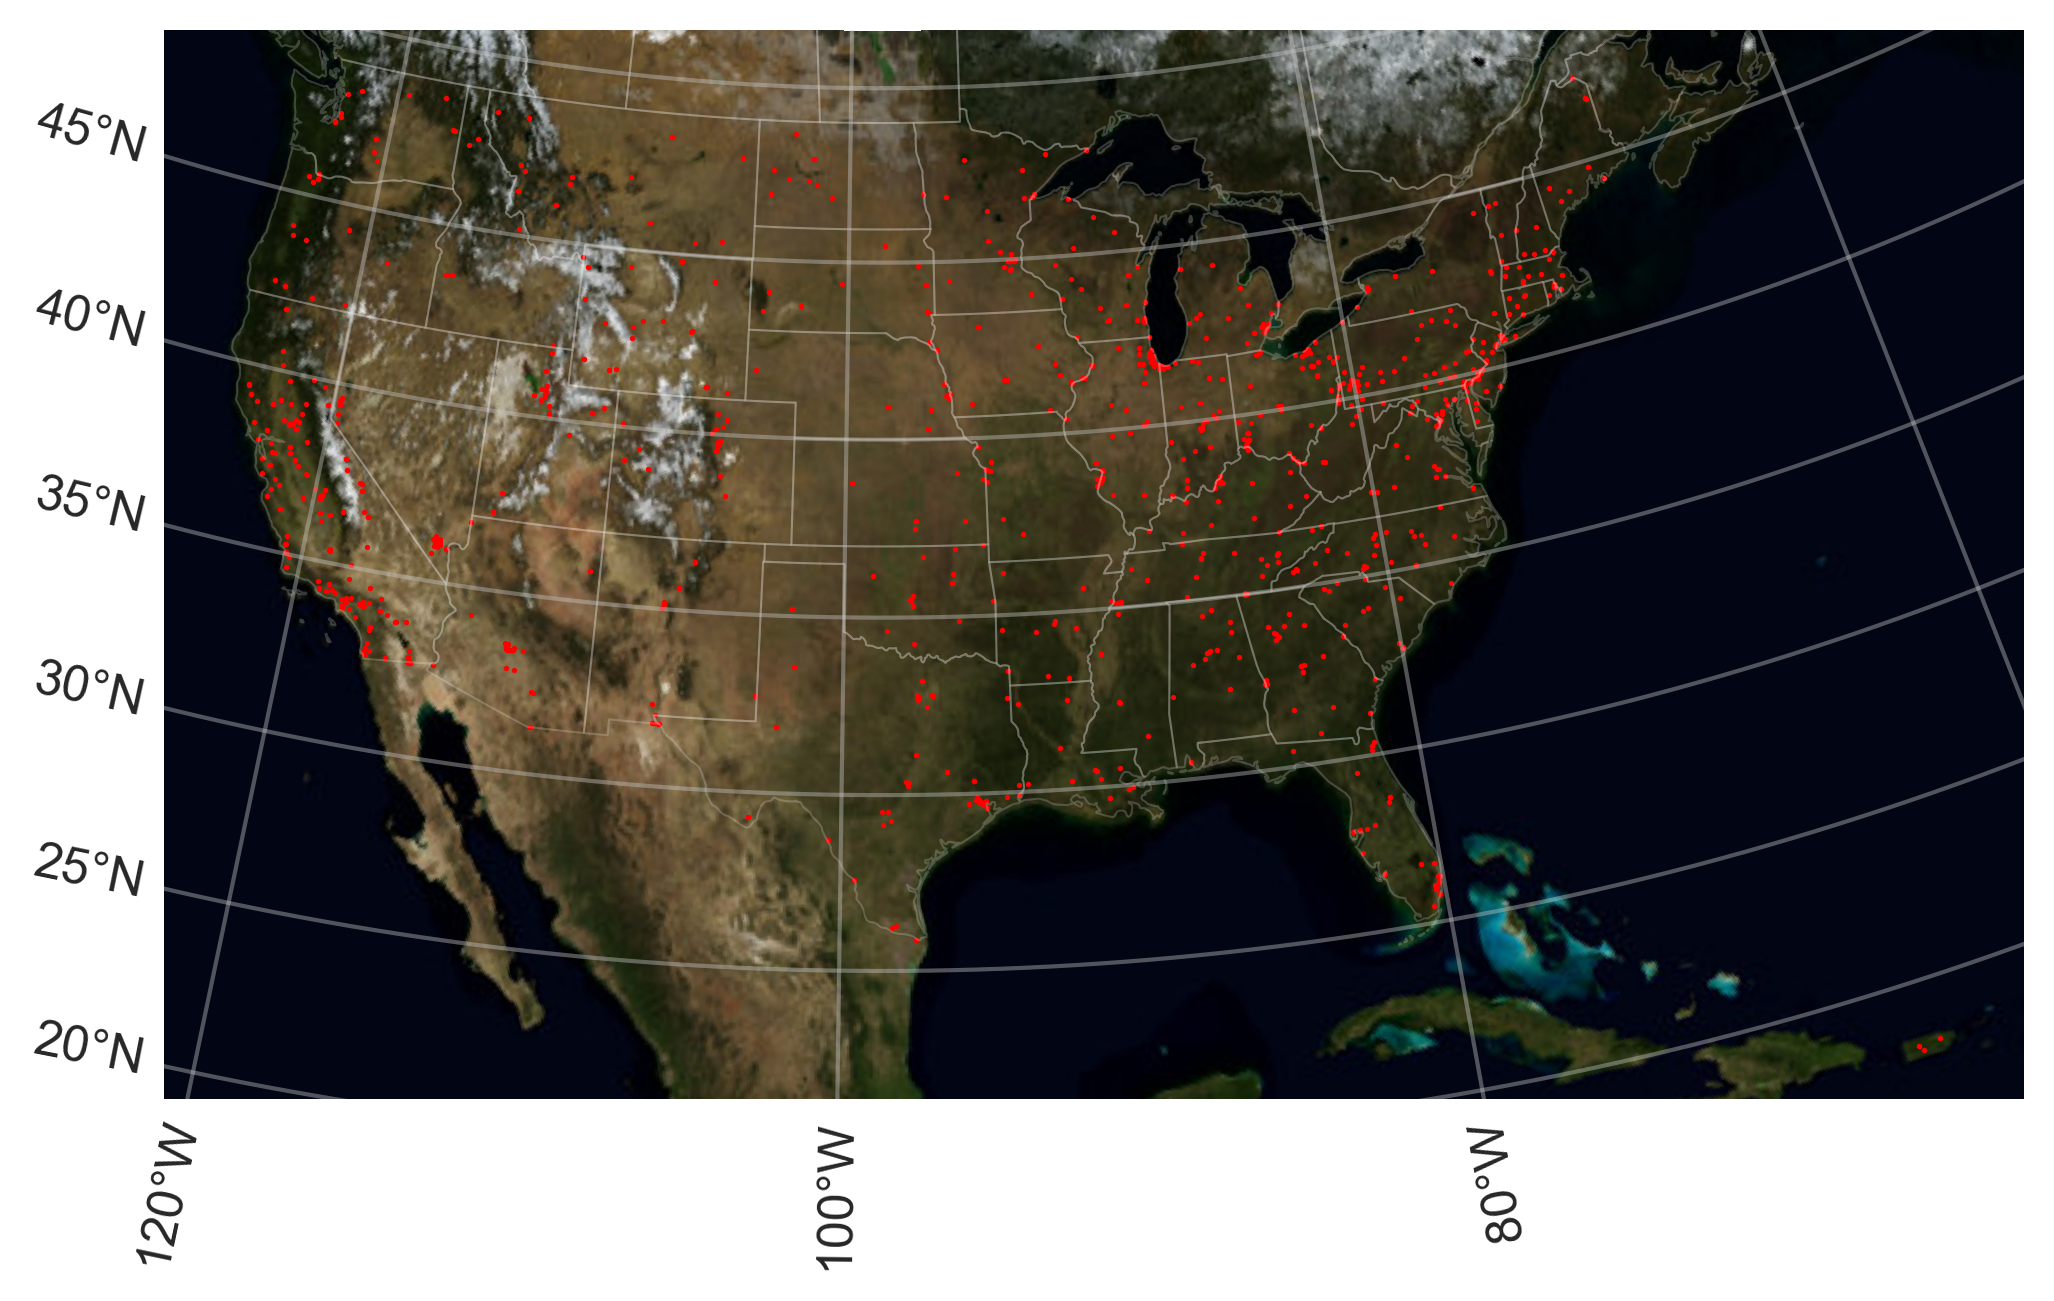

In [12]:
fig, ax = plt.subplots(dpi=300, subplot_kw={'projection': equal_area})

ax.scatter(matched.longitude, matched.latitude, 
           s=1, 
#            alpha=0.3, 
           color='red', 
           transform=plate)

# https://neo.gsfc.nasa.gov/wms/wms?version=1.3.0&service=WMS&request=GetCapabilities
ax.add_wms(wms='https://neo.gsfc.nasa.gov/wms/wms?version=1.3.0&service=WMS',
               layers=['BlueMarbleNG'])

ax.add_feature(cfeature.STATES, edgecolor='white', alpha=0.2, lw=0.5)

gl = ax.gridlines(draw_labels=True, alpha=0.4)
gl.top_labels = False
gl.right_labels = False
ax.spines['geo'].set_visible(False)

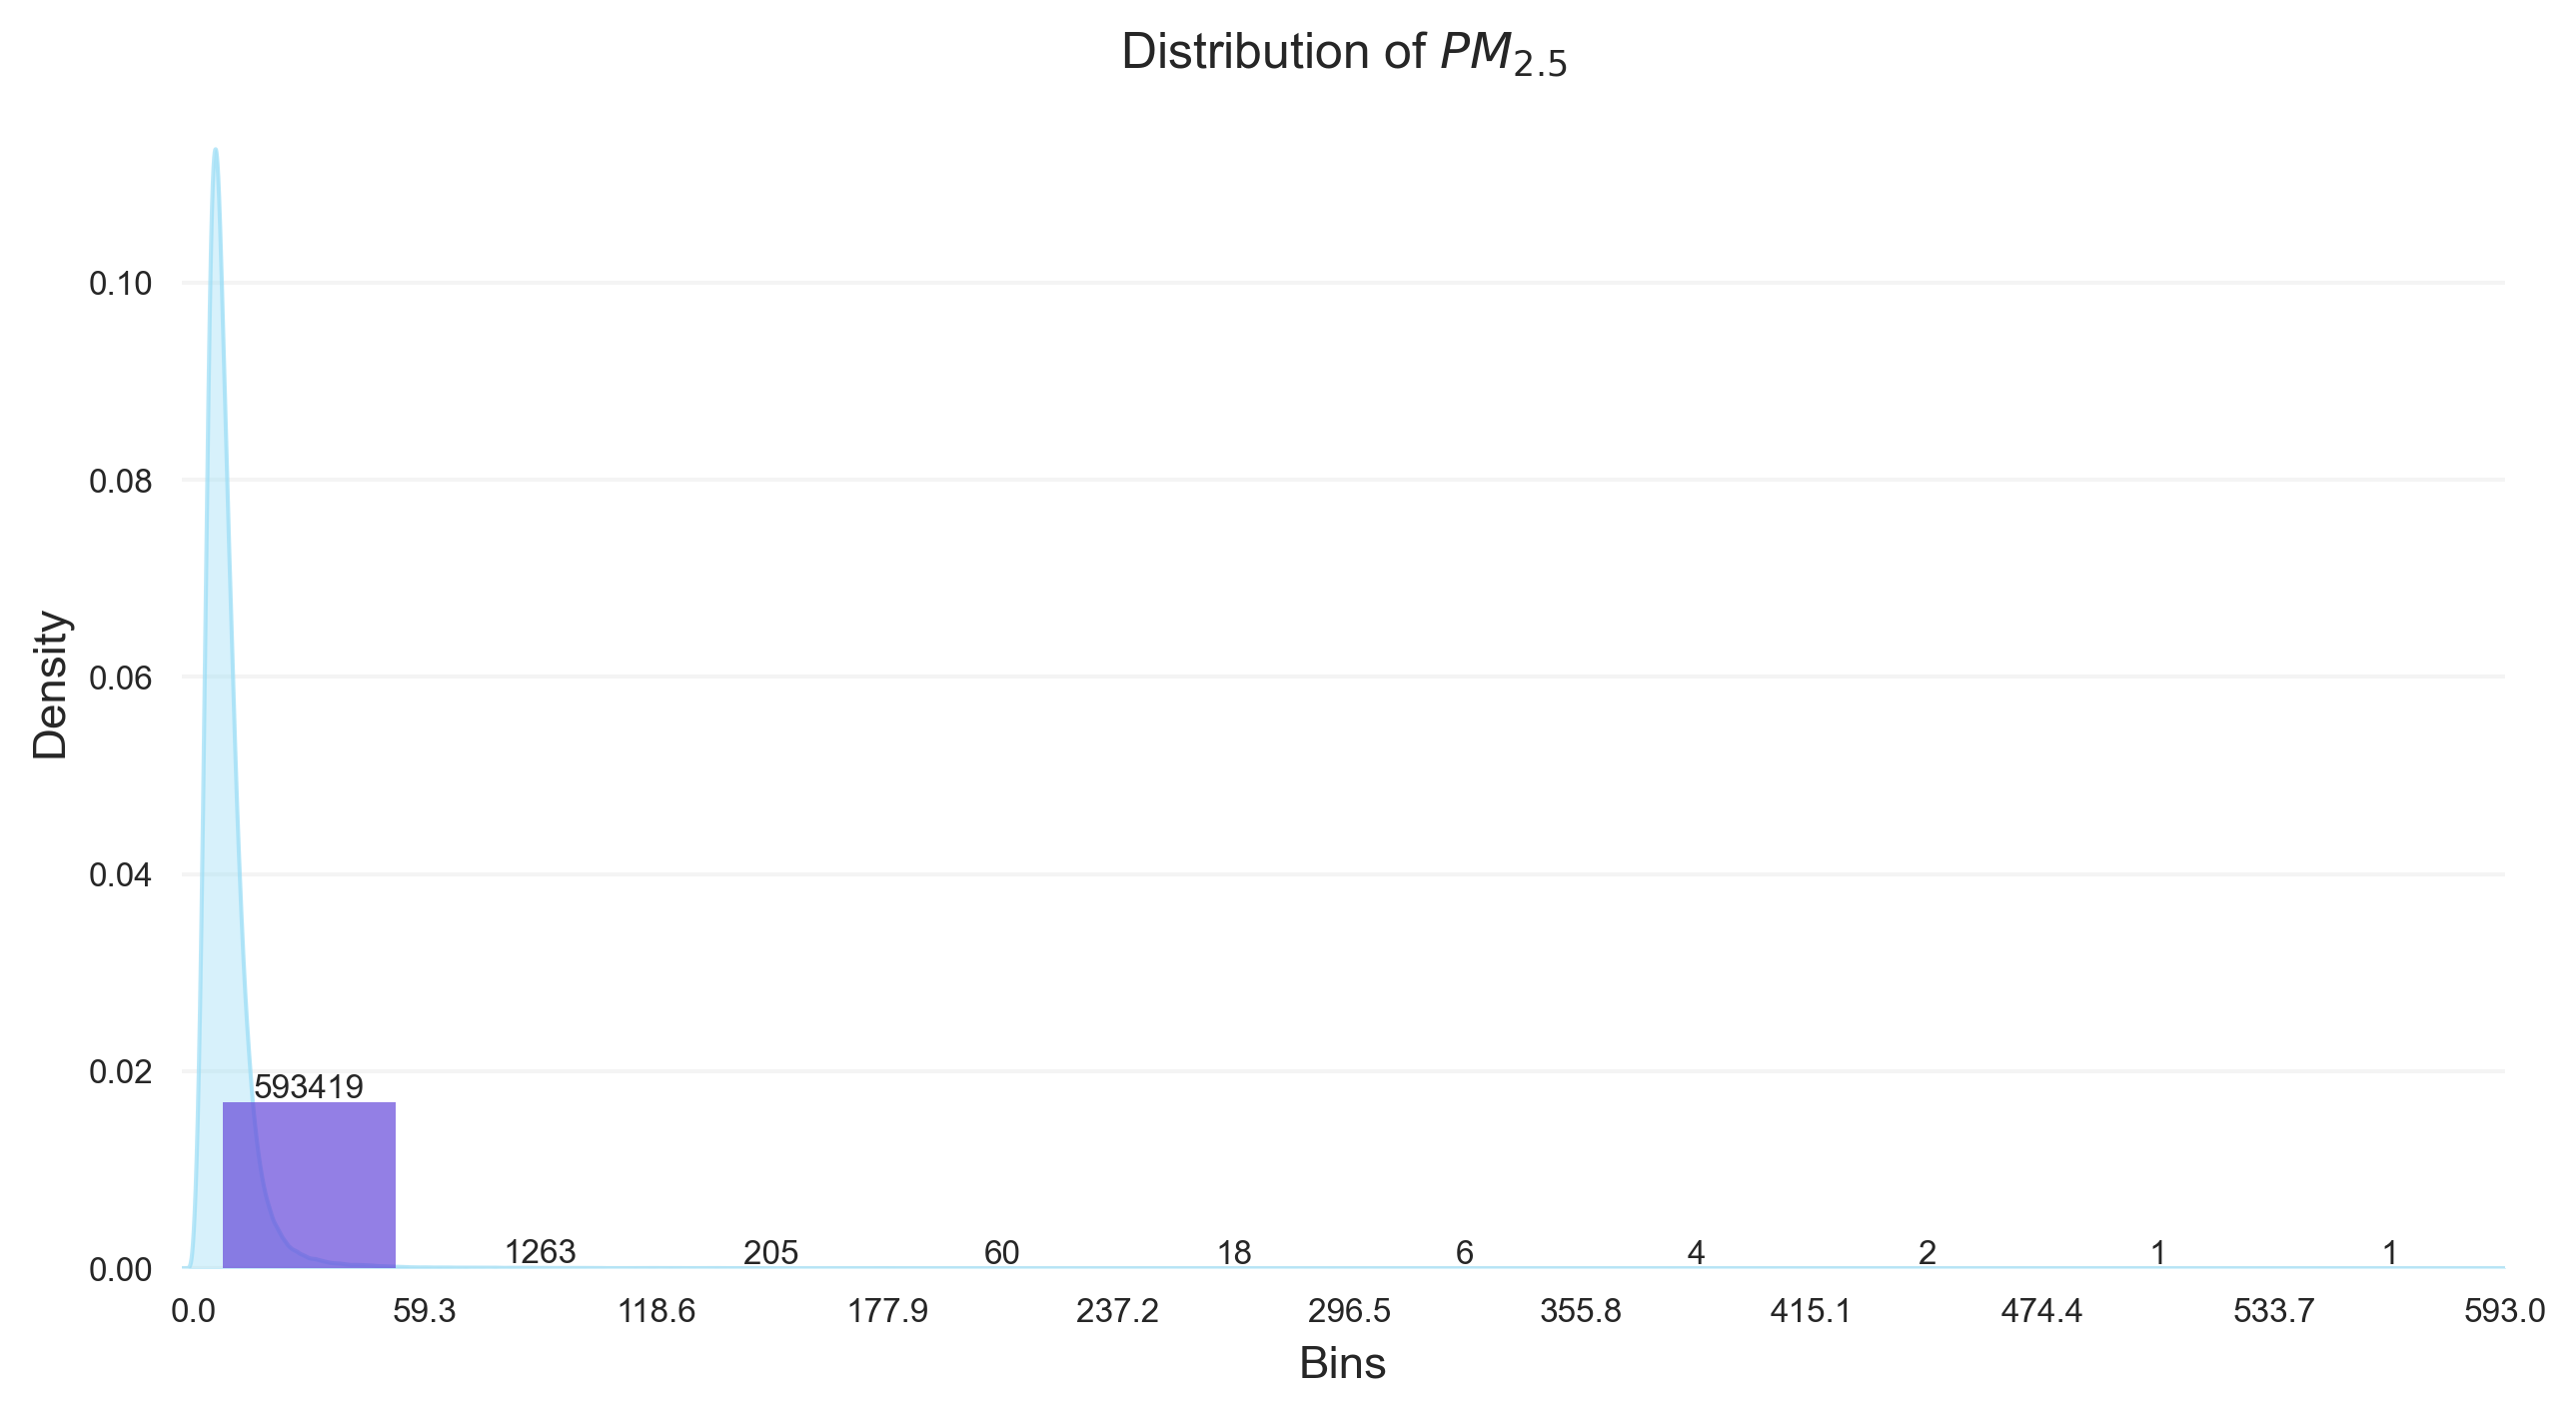

In [13]:
fig, ax = plt.subplots(dpi = 300, figsize=(10, 5.09))

bins = histogram_density_plot(df, 
                       by='PM25', 
                       nbins=10, 
                       title="Distribution of $PM_{2.5}$", 
                       tick_fontsize=8,
                       xlabel='Bins',
                       ylabel='Density',
                       xmin=-3, 
                       ax=ax)

ax.spines[:].set_visible(False)
ax.grid(False, axis='x')
ax.grid(True, axis='y')

# plt.savefig(os.path.join(paths.figures, 'distribution.png'))

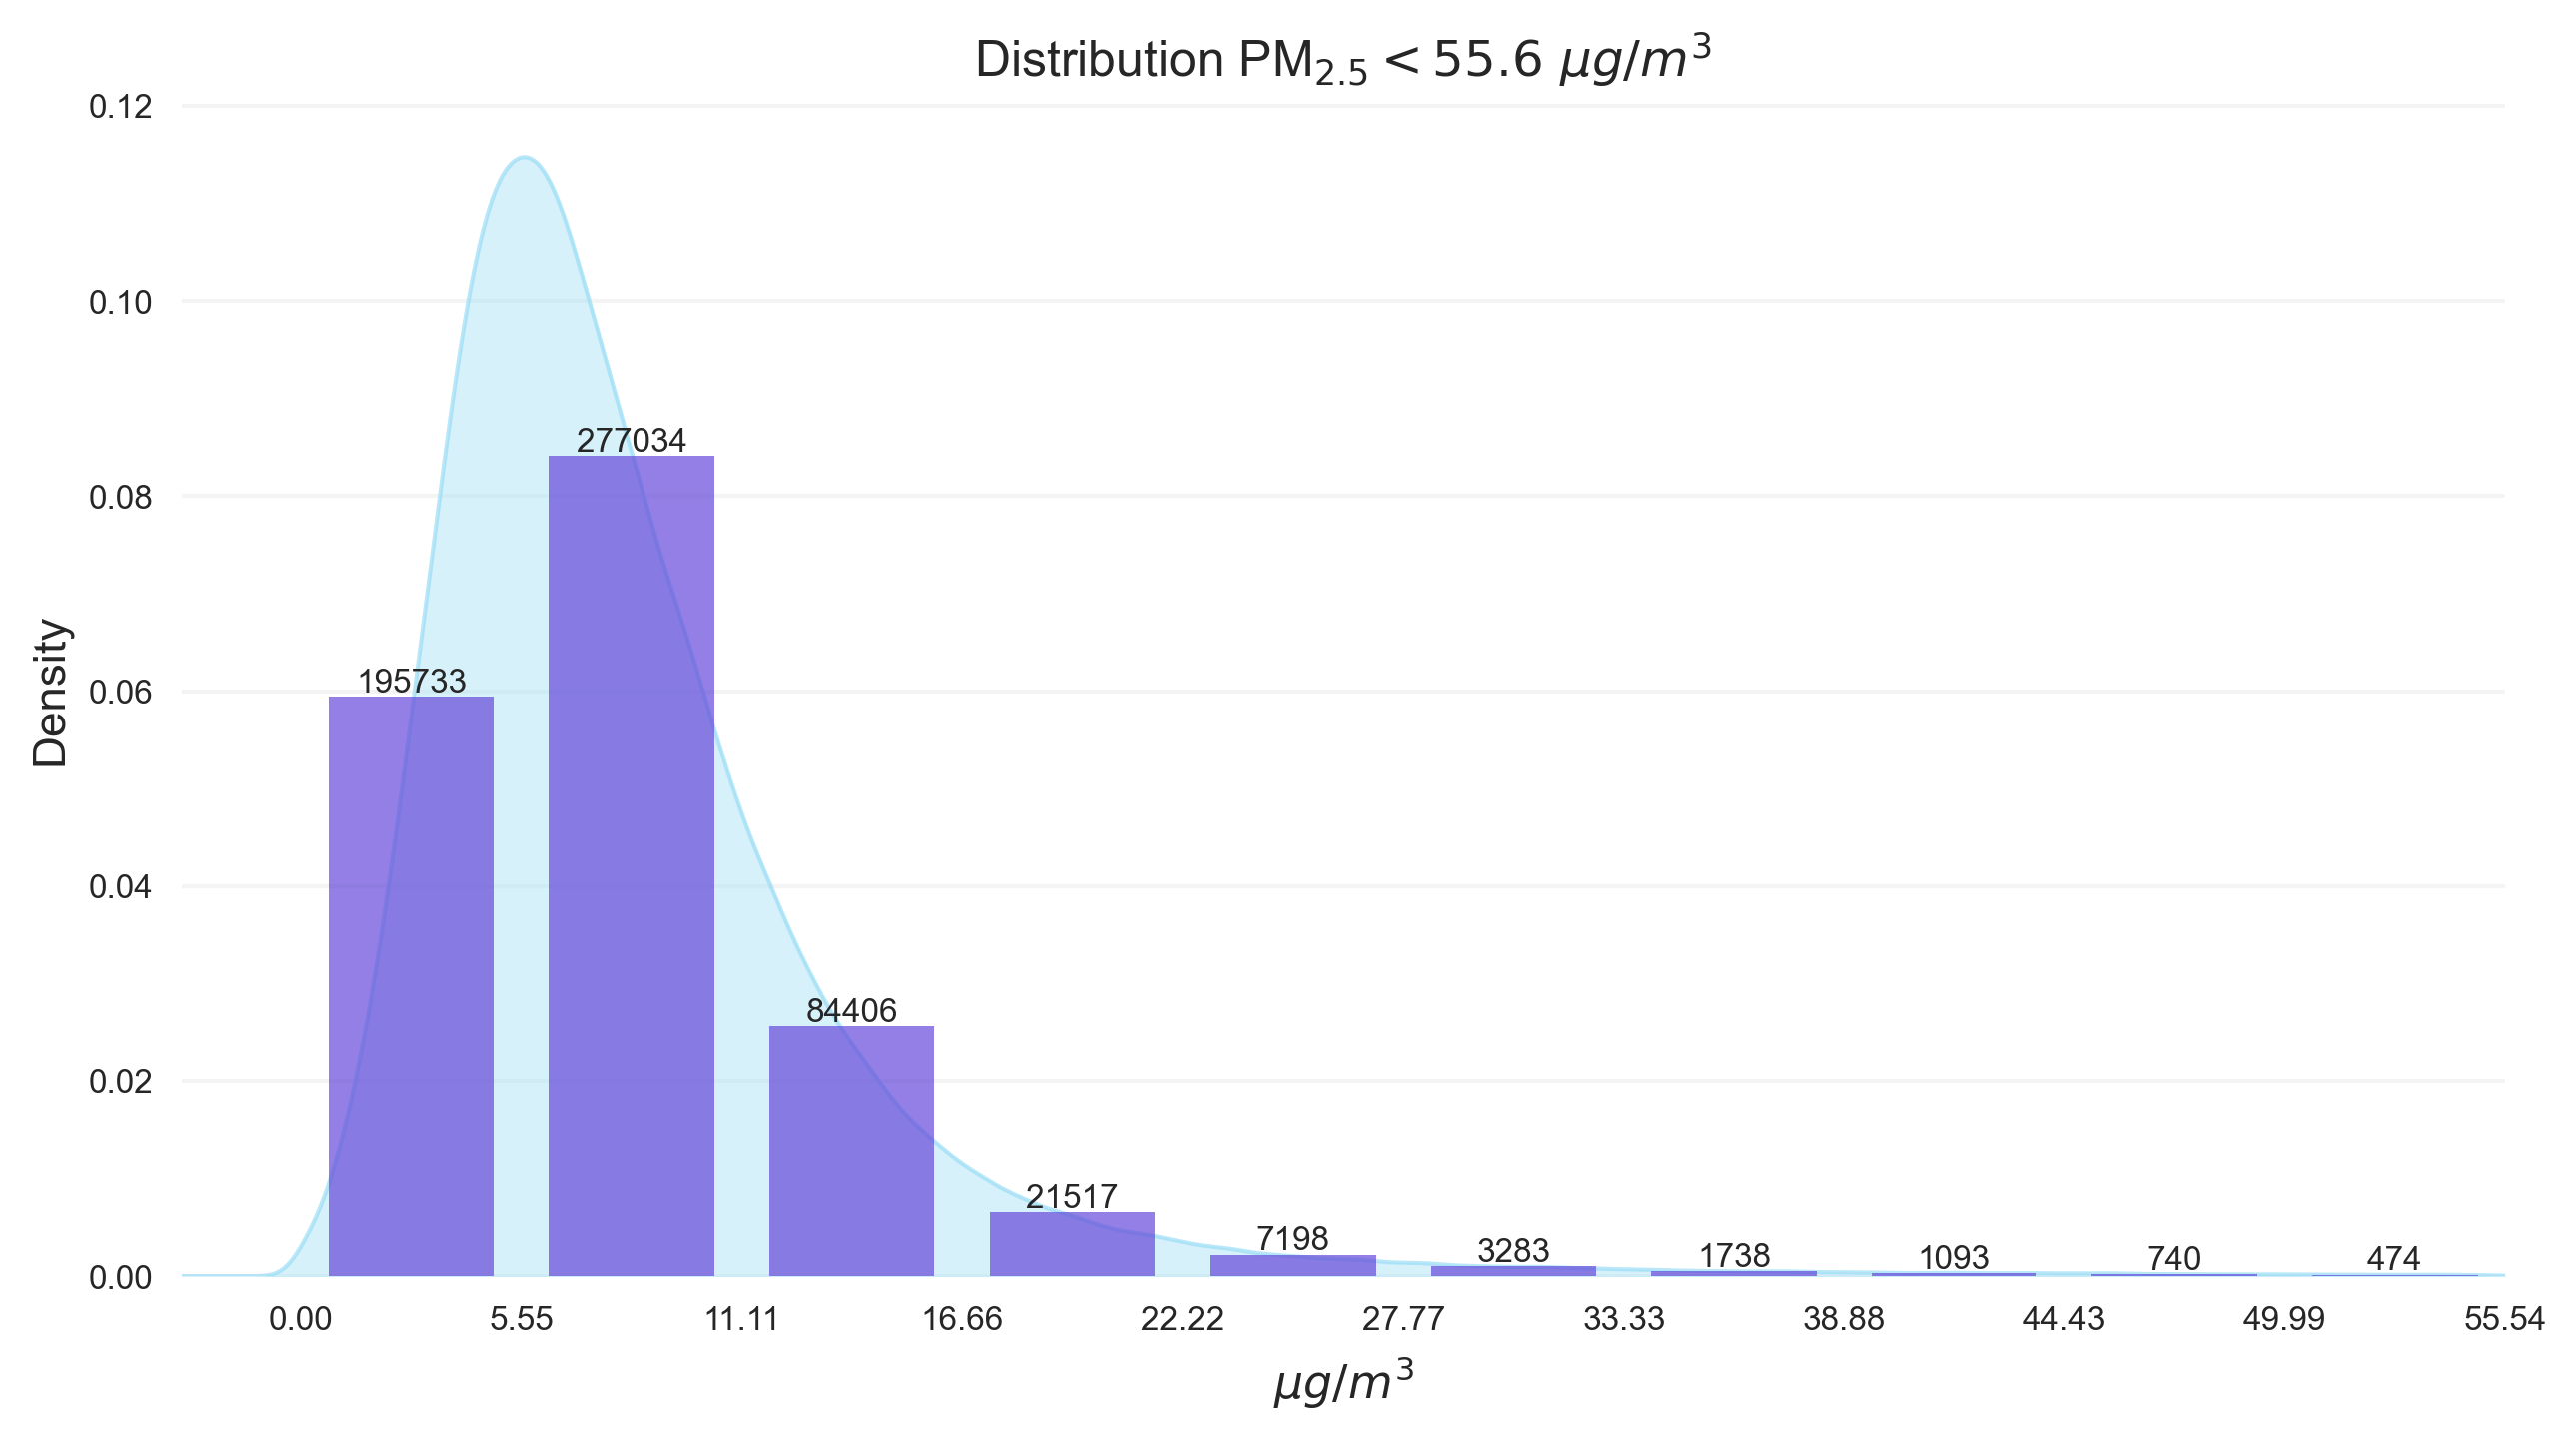

In [14]:
fig, ax = plt.subplots(dpi = 300, figsize=(10, 5.09))

bins = histogram_density_plot(df[df.PM25 < 55.6], 
                       by='PM25', 
#                        nbins=[0.0, 12.1, 35.5, 55.5], 
                       nbins=10,
                       title="Distribution PM$_{2.5} < 55.6~\mu g/m^3$", 
                       tick_fontsize=8,
                       xlabel='$\mu g/m^3$',
                       ylabel='Density',
                       xmin=-3, 
                       ax=ax)

ax.spines[:].set_visible(False)
ax.grid(False, axis='x')
ax.grid(True, axis='y')

fig.savefig(f'{save_path}/pm-densities.png', format='png', bbox_inches = "tight")

In [15]:
data = df.drop(['PM25', 'time'] + [f'month_{i}' for i in range(1,13)], axis=1)

In [16]:
data = data[['AOD', 't2m', 'skt', 'd2m', 'tp', 'u10', 'v10', 'blh', 'sp', 'lai_hv', 'lai_lv']]

data.columns

Index(['AOD', 't2m', 'skt', 'd2m', 'tp', 'u10', 'v10', 'blh', 'sp', 'lai_hv',
       'lai_lv'],
      dtype='object')

In [17]:
data['sp'] = data['sp'] / 100

In [18]:
data.columns = [
    'AOD 550$nm$',
    '2-meter Temperature $(K)$', 
    'Skin Temperature $(K)$',
    '2-meter Dew Point $(K)$', 
    'Total Precipitation $(m)$',
    '$U_{10}~(m s^{-1})$', 
    '$V_{10}~(m s^{-1})$', 
    'Boundary Layer Height $(m)$',
    'Surface Pressure $(hPa)$',
    'Leaf area index, high veg $(m^2 m^{-2})$', 
    'Leaf area index, low veg $(m^2 m^{-2})$', 
#     'Longitude',
#     'Latitude',
#     'January',
#     'February',
#     'March',
#     'April',
#     'May',
#     'June',
#     'July',
#     'August',
#     'September',
#     'October',
#     'November',
#     'December'
]


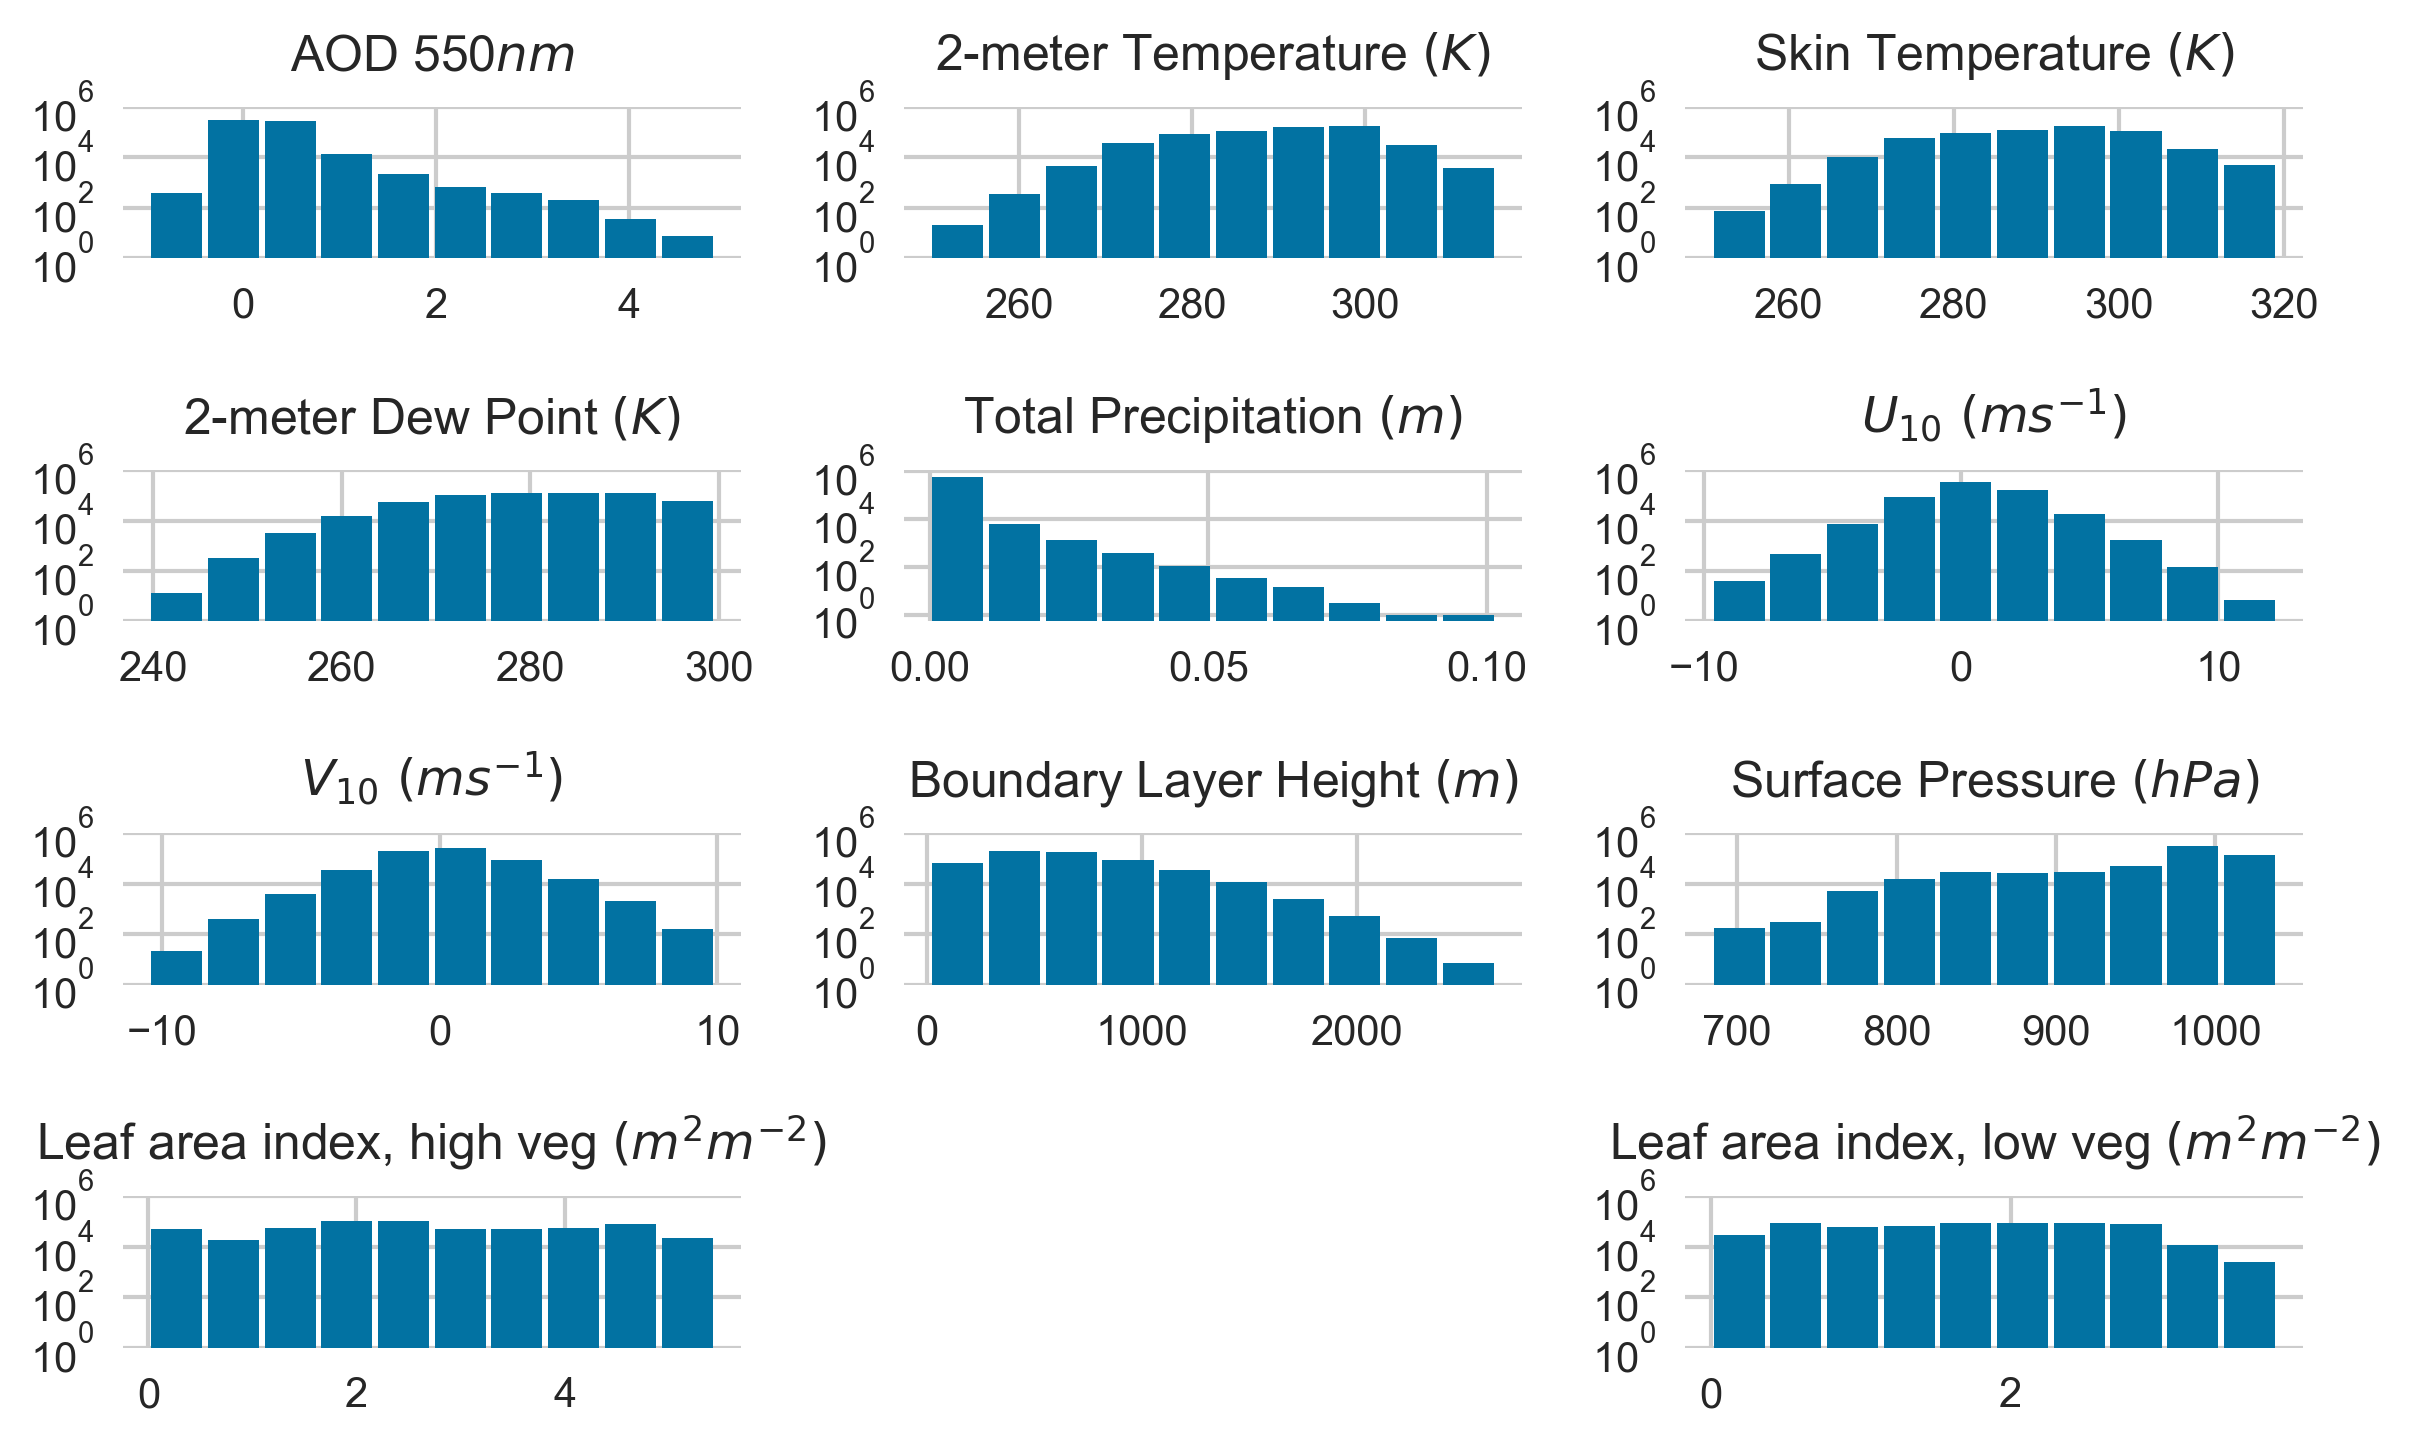

In [19]:
fig, axes = plt.subplots(4, 3, dpi=300, figsize=(8,5))

theax = np.array(axes.flatten()[:10].tolist() + axes.flatten().tolist()[11:12])

data.hist(ax=theax, rwidth=0.9)

no_spine = lambda ax: ax.spines[:].set_visible(False)
log = lambda ax: ax.set_yscale('log')
labels = lambda ax: ax.set_yticks(np.geomspace(1, 1e6, 4))
title = lambda ax: ax.set_title(ax.get_title(), y=1.08)
list(map(no_spine, axes.ravel()));
list(map(log, axes.ravel()))
list(map(title, axes.ravel()))
list(map(labels, axes.ravel()))

axes[3][1].set_visible(False)

fig.tight_layout()

fig.savefig(f'{save_path}/feature_histograms.png', format='png', bbox_inches = "tight")